In [19]:
from tqdm import tqdm
from pathlib import Path
import time
import json

import torch
from torch import nn
import torch.optim as optim
from torch.nn import functional as F

import numpy as np
import matplotlib.pyplot as plt

import simple_harmonic_oscillator as sho

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
torch.manual_seed(42)

In [20]:
checkpoint_dir = Path("checkpoints") / f"vae_{time.strftime('%Y%m%d-%H%M%S')}"
dataset_dir = Path("dataset")

config = {
    'epochs': 10,
    'lr': 1e-2,
    'batch_size': 32,
    'kl_weight': 0.1,
    'aa_weight': 0.1,
    'dim': 1,
    'n': 100, # how many samples per trajectory
    'dt': 0.1 # time difference between samples
}

### Possible Initial Conditions

True

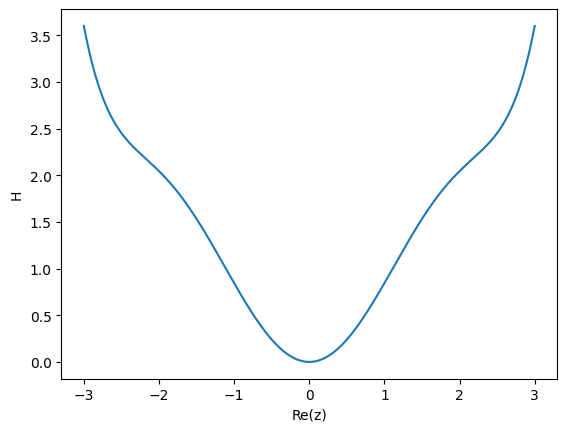

In [21]:
omega0_val = 1
h_f, dhdx_bar_f, xp_f = sho.hamiltonian_system()

z = np.linspace(-3, 3, 1000)
plt.plot(z, h_f(z + 0j, z - 0j, 1).real)
plt.xlabel("Re(z)")
plt.ylabel("H")

# Set initial condition for x and x̄ based on chosen 
# energy H as sqrt(H/omega_0) with phase as 0
desired_h = 2
x0 = sho.solve_for_x(h_f, desired_h, omega0_val)

np.allclose(2, h_f(x0, x0, omega0_val))

In [28]:
hamiltonians = np.arange(0, 3, 0.1)
num_random_starts = 10
random_start_range = (0, 10)
trajectory_duration = config['n'] * config['dt']

# Train Data
train_dset = []
for h_val in hamiltonians:
    x0 = sho.solve_for_x(h_f, h_val, omega0_val)
    random_starts = torch.randint(*random_start_range, (num_random_starts,))
    for tstart in random_starts:
        t_span = (tstart, tstart + trajectory_duration)
        t_eval = np.arange(*t_span, config['dt'])
        train_dset.append(sho.sample_trajectory(dhdx_bar_f, x0, omega0_val, t_span, t_eval))

# Test Data
test_dset = []
for h_val in hamiltonians:
    x0 = sho.solve_for_x(h_f, h_val, omega0_val)
    random_starts = torch.randint(*random_start_range, (num_random_starts,))
    t_span = (0, trajectory_duration)
    t_eval = np.arange(*t_span, config['dt'])
    test_dset.append(sho.sample_trajectory(dhdx_bar_f, x0, omega0_val, t_span, t_eval))

train_loader = torch.utils.data.DataLoader(torch.tensor(train_dset), batch_size=config['batch_size'])
test_loader = torch.utils.data.DataLoader(torch.tensor(train_dset), batch_size=config['batch_size'])

/var/folders/mq/cms649ss3rn_s1_jn2bt2dm40000gn/T/ipykernel_52524/943331436.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  t_eval = np.arange(*t_span, config['dt'])


In [29]:
# VAE code modified from: https://github.com/AntixK/PyTorch-VAE/blob/master/models/vanilla_vae.py
class Encoder(nn.Module):
    def __init__(self, dim: int, layers: int):
        super(Encoder, self).__init__()
        self.dim = dim
        self.num_layers = layers

        modules = []
        for _ in range(self.num_layers):
            modules.append(nn.Linear(self.dim, self.dim))
        
        self.layers = nn.Sequential(*modules)

        self.fc_mu = nn.Linear(self.dim, self.dim)
        self.fc_var = nn.Linear(self.dim, self.dim)
    
    def forward(self, x):
        x = self.layers(x)

        mu = self.fc_mu(x)
        logvar = self.fc_var(x)

        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, dim: int, layers: int):
        super(Decoder, self).__init__()

        self.dim = dim
        self.num_layers = layers

        modules = []
        for _ in range(self.num_layers):
            modules.append(nn.Linear(self.dim, self.dim))
        
        self.layers = nn.Sequential(*modules)

class ActionAngleVAE(nn.Module):
    def __init__(self, layers: int, dim: int, dt: float, n):
        super(ActionAngleVAE, self).__init__()
        
        self.num_layers = layers
        
        # Dimension of the problem (eg 1 for SHO)
        self.dim = dim
        # Integration timestep
        self.dt = dt
        # Integration timesteps
        self.n = n

        self.encoder = Encoder(self.dim*2, self.num_layers)
        self.decoder = Decoder(self.dim*2, self.num_layers)
    
    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu
    
    def forward(self, x):
        # x is a tensor of shape [batch, n, dim*2]
        mu, logvar = self.encoder(x)

        J = z[:, :, :self.dim]
        phi_dot = z[:, :, self.dim:]
        phi = self.integrate_phi_dot(phi_dot)
        
        z = self.reparameterize(torch.stack(J, phi), logvar)

        return self.decoder(z), mu, logvar, phi

    def integrate_phi_dot(self, phi_dot: torch.Tensor) -> torch.Tensor:
        phi = torch.zeros_like(phi_dot)
        for i in range(1, self.n):
            phi[:,i] + phi_dot[:,i] * self.dt
        
        return phi

In [30]:
def loss_fn(recon, mu, logvar, phi, x, config):
    recon_loss = F.mse_loss(recon, x)

    kl_loss = torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)

    # Minimize the change in action and derivative of angle over time
    J = mu[:, :, :config['dim']]
    phi_dot = mu[:, :, config['dim']:]
    aa_loss = torch.sum(J - J.mean(), axis=1) + torch.sum(phi_dot - phi_dot.mean(), axis=1)

    loss = recon_loss + config['kl_weight']*kl_loss + config['aa_weight']*aa_loss

    return loss, recon_loss, kl_loss, aa_loss

In [31]:
model = ActionAngleVAE(layers=2, dim=config['dim'], dt=config['dt'], n=config['n']).to(device)
optimizer = optim.SGD(model.parameters(), lr=config['lr'])

In [32]:
running_loss = []
running_mse = []
running_kl = []
running_aa = []

pbar = tqdm(range(config['epochs']))
for epoch in pbar:
    total_loss, total_mse, total_kl, total_aa = 0.0, 0.0, 0.0, 0.0
    for batch_idx, x in enumerate(train_loader):
        optimizer.zero_grad()
        
        recon, mu, logvar, phi, J = model(x)
        loss, mse_loss, kl_loss, aa_loss = loss_fn(recon, mu, logvar, phi)

        total_loss += loss
        total_mse += mse_loss
        total_kl += kl_loss
        total_aa += aa_loss

        loss.backward()
        optimizer.step()

    pbar.set_postfix_str(f"Loss: {total_loss/len(train_loader):.2f}")
    running_loss.append(total_loss / len(train_loader))
    running_mse.append(total_mse / len(train_loader))
    running_kl.append(total_kl / len(train_loader))
    running_aa.append(total_aa / len(train_loader))

torch.save(model.state_dict(), checkpoint_dir / 'ckpt.pt')
with open(checkpoint_dir/'config.json', 'w') as f:
    json.dump(config, f)

  0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: MPS device does not support linear for non-float inputs

In [ ]:
plt.plot(running_loss, label='Total Loss')
plt.plot(running_mse, label='MSE Loss')
plt.plot(running_kl, label='KL Loss')
plt.plot(running_aa, label='AA Loss')

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
def aa_plot(axs, J, phi, **kwargs):
    axs[0].plot(torch.cos(phi)*J, torch.sin(phi)*J, **kwargs)
    axs[1].plot(phi, J, **kwargs)

In [ ]:
sample_batch = next(iter(test_loader))
i = 0
orig_J = sample_batch[i, :config['dim']]
orig_phi = sample_batch[i, config['dim']:]

true_J, true_phi = AA_transformation(orig_J, orig_phi)

mu, logvar = model.encoder(sample_batch)
J = mu[:config['dim']]
phi_dot = mu[config['dim']:]
phi = model.integrate_phi_dot(phi_dot)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
aa_plot(axs, orig_J, orig_phi, {'label': 'original', 'c': 'grey'})
aa_plot(axs, true_J, true_phi, {'label': 'original', 'c': 'black'})
aa_plot(axs, J[i], phi[i], {'label': 'predicted'})
